In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data-projet7.csv', decimal =".")
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


In [3]:
data.shape

(11599, 6)

In [4]:
for i in data.columns:
    print("La colonne '{}' :".format(i), any(pd.isna(data[i])))


La colonne 'country' : False
La colonne 'year_survey' : False
La colonne 'quantile' : False
La colonne 'nb_quantiles' : False
La colonne 'income' : False
La colonne 'gdpppp' : True


<p> Des valeurs NaN sont présentes dans la colonne 'gdpppp' </p>

In [5]:
data['gdpppp'] = data['gdpppp'].fillna(0)
#Voir après par quoi remplacer, 0 n'étant peut-être pas le bon chiffre

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
country         11599 non-null object
year_survey     11599 non-null int64
quantile        11599 non-null int64
nb_quantiles    11599 non-null int64
income          11599 non-null object
gdpppp          11599 non-null object
dtypes: int64(3), object(3)
memory usage: 543.8+ KB


Aucune colonne nulle ; Par contre on peut voir que 'income' et 'gdpppp' sont object et non numeric

In [7]:
data['gdpppp'] = data['gdpppp'].astype(str)
data['gdpppp'] = [x.replace(',', '.') for x in data['gdpppp']]
data['gdpppp'] = pd.to_numeric(data['gdpppp'])

data['income'] = data['income'].astype(str)
data['income'] = [x.replace(',', '.') for x in data['income']]
data['income'] = pd.to_numeric(data['income'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
country         11599 non-null object
year_survey     11599 non-null int64
quantile        11599 non-null int64
nb_quantiles    11599 non-null int64
income          11599 non-null float64
gdpppp          11599 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


On a bien nos colonnes 'income' et 'gdpppp' en float et plus en object

In [9]:
data.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599.000000,11599.000000,11599.0,11599.000000,1.159900e+04
mean,2007.982757,50.500819,100.0,6069.224260,4.935532e+04
std,0.909633,28.868424,0.0,9414.185972,3.966582e+05
min,2004.000000,1.000000,100.0,16.719418,0.000000e+00
25%,2008.000000,25.500000,100.0,900.685515,2.340000e+03
50%,2008.000000,51.000000,100.0,2403.244900,7.505000e+03
75%,2008.000000,75.500000,100.0,7515.420900,1.838850e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


# Mission 1

## Années des données utilisées

<p> Testons d'abord que les données ont bien une année pour chaque pays : </p>

In [10]:
for i in range(2004,2012):
    country_year  = data[data['year_survey'] == i]
    print("Le nombre de pays pour l'année {} est de : ".format(i))
    print(len(country_year['country'].unique()))

Le nombre de pays pour l'année 2004 est de : 
1
Le nombre de pays pour l'année 2005 est de : 
0
Le nombre de pays pour l'année 2006 est de : 
5
Le nombre de pays pour l'année 2007 est de : 
15
Le nombre de pays pour l'année 2008 est de : 
76
Le nombre de pays pour l'année 2009 est de : 
12
Le nombre de pays pour l'année 2010 est de : 
6
Le nombre de pays pour l'année 2011 est de : 
1


<p> Ce n'est pas le cas, deux solutions s'offrent donc à nous : <br/>
<ol><li>Prendre uniquement l'année ayant le plus de pays (ici 2008) </li>
    <li>Prendre une année par pays (mais problème dans nombre d'individus)</li></ol>
</p>

<p> Afin d'éviter les comparaisons d'indice de gini et de population entre plusieurs années, nous prendrons uniquement l'année 2008 pour cette étude.</p>

In [11]:
data = data[data['year_survey'] == 2008]

## Nombre de pays présents

In [12]:
print('Le nombre de pays est de : ',len(data['country'].unique()), "pour l'année 2008")

Le nombre de pays est de :  76 pour l'année 2008


## Population couverte par l'analyse (%age de la population mondiale)

<p> Pour ce pourcentage nous prendront comme base la population mondiale de chaque année concernée. Nous établierons ensuite la moyenne de toutes ces années. </p>

In [13]:
pop = pd.read_csv('pop.csv')
pop = pop[pop['Year'] == 2008]
pop = pop[['Country', 'Countrycode3', 'Year', 'Population', 'PopCovr_new']]
pop = pop.drop_duplicates()
pop.head()
#A merge avec l'autre df, voir ensuite avec le % de population pour chaque pays

,Country,Countrycode3,Year,Population,PopCovr_new
1,Afghanistan,AFG,2008,27.658890,All
5,Albania,ALB,2008,2.968026,All
10,Angola,AGO,2008,19.842251,All
164,Argentina,ARG,2008,40.381860,All
239,Armenia,ARM,2008,2.975029,All


In [14]:
data_pop = pd.merge(data, pop, left_on=['country', 'year_survey'], 
                    right_on=['Countrycode3', 'Year'], how='left')
data_pop = data_pop.rename(columns={'country':'code', 'year_survey':'year'})

#On ne conserve que les individus dont la population couverte est all
data_pop = data_pop[data_pop['PopCovr_new'] == 'All']
data_pop = data_pop[['code', 'Country', 'Population']]

#On groupby pour avoir une seul ligne par pays
data_pop = data_pop.groupby(['code', 'Country', 'Population']).count()
data_pop = data_pop.reset_index()

data_pop.head()

,code,Country,Population
0,ALB,Albania,2.968026
1,ARG,Argentina,40.381860
2,ARM,Armenia,2.975029
3,AUT,Austria,8.331465
4,AZE,Azerbaijan,8.868713


<p> La population totale dans le monde en 2008 était de : 6.766 Milliard selon le site : <br/> <a>https://donnees.banquemondiale.org/indicateur/sp.pop.totl?end=2017&start=2008</a>

In [15]:
pop_tot = 6766
print("Le pourcentage de population couvert par cette étude est de :", 
      round(data_pop['Population'].sum()/pop_tot*100), "%")

Le pourcentage de population couvert par cette étude est de : 29.0 %


## De quel type de quantile s'agit-il 

<p> Les quantiles utilisés dans les données sont des centiles. <br/>
    Le centile nous permet d'être précis dans nos calculs ; Et n'enlève pas la possibilité de prendre plus large (en décile par exemple).
</p>

## PPP

<p> Le PPP (Purchasing Power Parity) permet de prendre en compte non seulement les revenus des habitant mais aussi le coût de la vie dans le pays. <br/>
    Il est donc de ce fait beaucoup plus précis sur la richesse des habitants. </p>

# Mission 2

## Diversité des pays 

In [16]:
#Définition d'une fonction decile pour transformer les centiles en déciles
def decile (value):
    if 0<=int(value)<11 :
        return int(1)
    elif 11<=int(value)<21:
        return int(2)
    elif 21<=int(value)<31:
        return int(3)
    elif 31<=int(value)<41:
        return int(4) 
    elif 41<=int(value)<51:
        return int(5) 
    elif 51<=int(value)<61:
        return int(6) 
    elif 61<=int(value)<71:
        return int(7) 
    elif 71<=int(value)<81:
        return int(8) 
    elif 81<=int(value)<91:
        return int(9) 
    elif 91<=int(value)<101:
        return int(10) 
    else:
        return 'ERROR'
    
#Automatisation avec boucle ici ? Voir comment, chronophage à la main

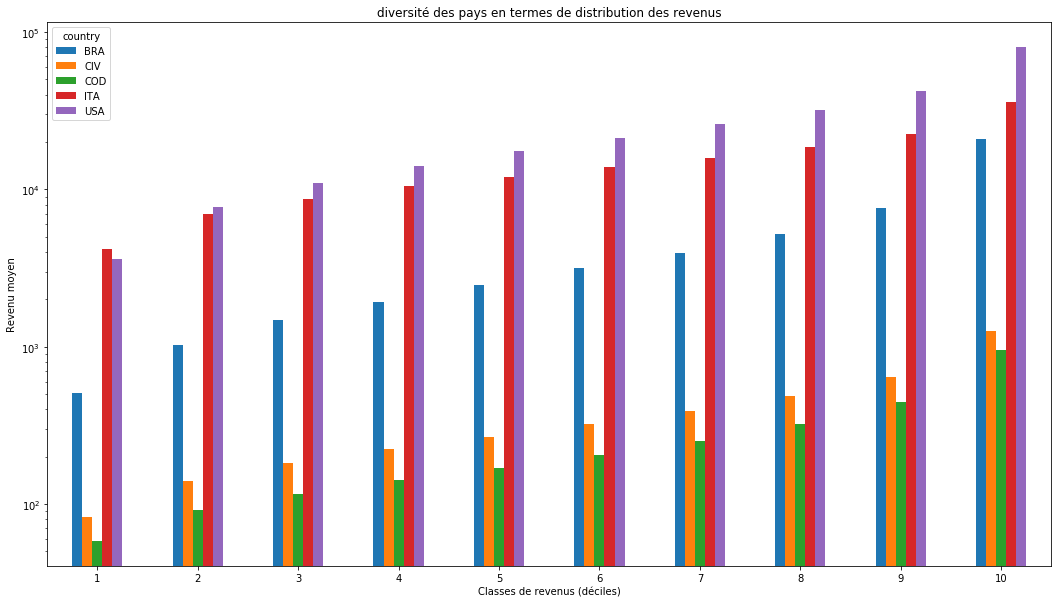

In [17]:
np.random.seed(1)
sample = np.random.randint(76, size=5)
X = data['country'].unique()[sample]
sampled_data = data[data.country.isin(X)]

sampled_data = sampled_data.reset_index()
#On applique la fonction decile au df : 
sampled_data['decile'] = sampled_data['quantile'].map(decile)

sampled_crosstab = pd.crosstab(index=sampled_data["decile"], 
                           columns=sampled_data["country"], 
                           values=sampled_data["income"],
                          aggfunc = np.mean)
#print(sampled_crosstab)
sampled_crosstab.plot(kind="bar", figsize=(18,10), stacked=False)
plt.title("diversité des pays en termes de distribution des revenus")
plt.xlabel("Classes de revenus (déciles)")
plt.ylabel("Revenu moyen")
plt.yscale('log')
plt.xticks(rotation = 'horizontal')
plt.yticks(rotation = 'horizontal')
plt.savefig("Graphiques/diversité_pays.png")
plt.show()

<p> Ici les classes ont été passées en décile et non centile (pour plus de lisibilité), voir si on garde comme ça.</p>

## Courbe de Lorenz

### Définition de la fonction : 

In [18]:
def lorenz(df, name=None):
    #On prend uniquement les colonnes utiles :
    data_gini = df[['country', 'quantile', 'income']]
    
    #Calcul du coef de gini et courbe de Lorenz : 
    fig, ax = plt.subplots(figsize=[12,12])
    for pays in data_gini['country'].unique():
        #Gini
        array = data_gini[data_gini['country'] == pays]['income']
        array = np.sort(array) #values must be sorted
        index = np.arange(1,array.shape[0]+1) #index per array element
        n = array.shape[0]#number of array elements
        coef = ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))
        
        #Courbe de Lorenz
        data_lorenz = data_gini[data_gini['country'] == pays]['income'].sort_values()
        data_lorenz = data_lorenz.cumsum() / data_lorenz.sum()

        ## Mise en place de la courbe
        ax.plot(np.arange(data_lorenz.size)/(data_lorenz.size-1)*100, data_lorenz*100, 
                    label=pays)

        ## courbe à coéfficient d'égalité : 
        ax.plot([0,100], [0,100], color='black')
        plt.title("Courbe de Lorenz")
        plt.xlabel("Part cumulée de la population")
        plt.ylabel("Part cumulée des revenus")
        plt.legend()
    plt.savefig("Graphiques/courbes_de_lorenz.png")
    plt.show()

### Les courbes 

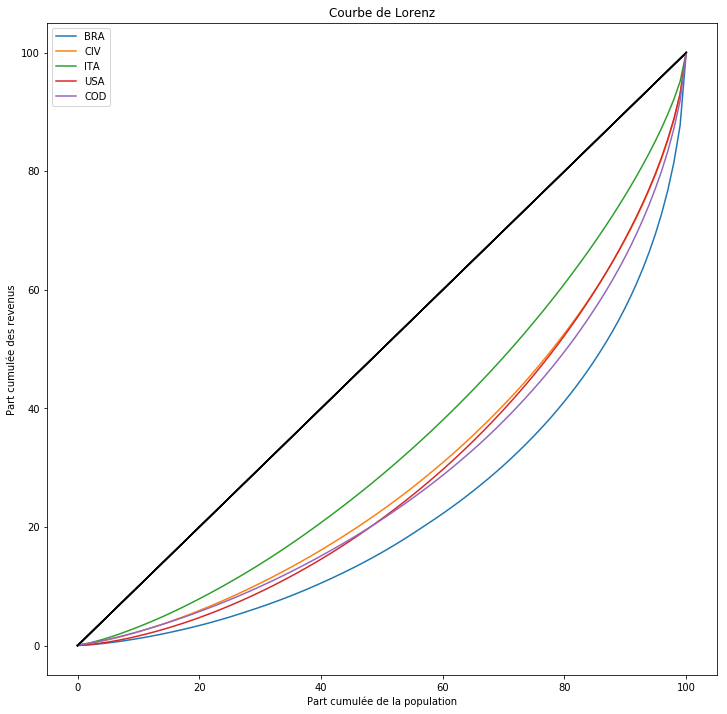

In [19]:
lorenz(sampled_data)

## Evolution de l'indice de Gini au fil des ans 

<p> Pour cette question nous allons prendre le fichier traité dans le fichier "gini" </p>

In [20]:
indice_gini = pd.read_csv("gini.csv")
indice_gini = indice_gini[['Country', 'Countrycode3', 'Year', 'Gini']]
indice_gini = indice_gini.groupby(['Country','Countrycode3', 'Year']).mean()
indice_gini = indice_gini.reset_index()
indice_gini.head()

,Country,Countrycode3,Year,Gini
0,Afghanistan,AFG,2007,29.00
1,Afghanistan,AFG,2008,27.80
2,Albania,ALB,1996,28.00
3,Albania,ALB,2002,31.74
4,Albania,ALB,2005,30.60


Les indices sont ici multipliés par 100, attention si courbes de Lorenz après.

In [21]:
sampled_gini = indice_gini[indice_gini["Countrycode3"].isin(X)]
sampled_gini.head()

,Country,Countrycode3,Year,Gini
371,Brazil,BRA,1958,49.100000
372,Brazil,BRA,1960,54.184615
373,Brazil,BRA,1970,57.418182
374,Brazil,BRA,1972,61.000000
375,Brazil,BRA,1974,55.300000


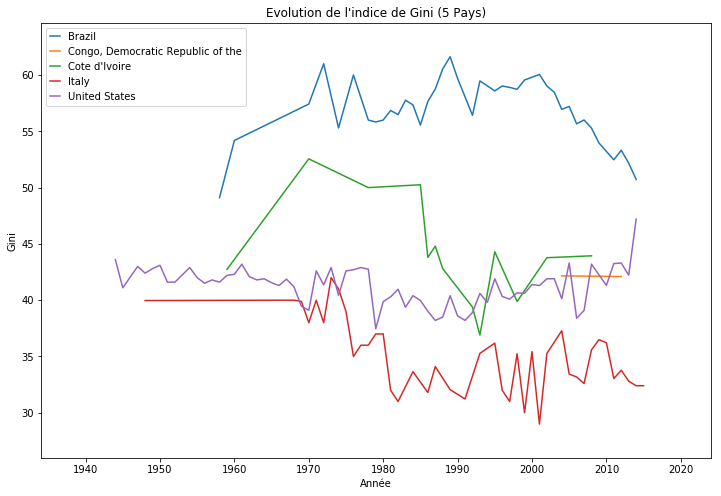

In [22]:
plt.figure(figsize=[12,8])
for pays in sampled_gini['Country'].unique():    
    Y = sampled_gini[sampled_gini['Country'] == pays]
    plt.plot(Y['Year'], Y['Gini'], label=pays)
    plt.title("Evolution de l'indice de Gini (5 Pays)")
    plt.xlabel('Année')
    plt.ylabel('Gini')
    plt.legend(handlelength = 1)
    #On set la limit au min et max des 5 pays pour avoir la même échelle
    plt.ylim(sampled_gini['Gini'].min()-3,sampled_gini['Gini'].max()+3)
    plt.xlim(Y['Year'].min()-10, Y['Year'].max()+10)
plt.savefig('Graphiques/evolution_gini.png')
plt.show()

## Classement des pays par indice de Gini 

### Calcul des indices de Gini pour chaque pays 

On se sert du fichier indice_gini pour récupérer les indices

In [23]:
data_gini = pd.merge(data, indice_gini, left_on=['country', 'year_survey'], 
                     right_on=['Countrycode3', 'Year'], how='left')
data_gini = data_gini[['Country', 'country', 'year_survey', 
                       'quantile', 'nb_quantiles', 'income', 
                       'gdpppp', 'Gini']]
data_gini = data_gini.rename(columns={'country':'code', 'year_survey':'annee'})
data_gini.head()

,Country,code,annee,quantile,nb_quantiles,income,gdpppp,Gini
0,Albania,ALB,2008,1,100,728.89795,7297.0,29.98
1,Albania,ALB,2008,2,100,916.66235,7297.0,29.98
2,Albania,ALB,2008,3,100,1010.91600,7297.0,29.98
3,Albania,ALB,2008,4,100,1086.90780,7297.0,29.98
4,Albania,ALB,2008,5,100,1132.69970,7297.0,29.98


In [24]:
data_gini[pd.isna(data_gini['Gini'])].groupby(['code']).count()

,Country,annee,quantile,nb_quantiles,income,gdpppp,Gini
code,,,,,,,
COD,0,100,100,100,100,100,0
IRN,0,100,100,100,100,100,0
IRQ,0,100,100,100,100,100,0
PAK,0,100,100,100,100,100,0
XKX,0,100,100,100,100,100,0
YEM,0,100,100,100,100,100,0


<p> 6 Pays du fichier n'ont pas d'indice de Gini (indice manquant dans le fichier source). </p>
<p> Nous allons donc devoir le calculer directement </p>

In [25]:
def calcul_gini(code):
    array = data_gini[data_gini['code'] == code]['income']
    array = np.sort(array) #On sort les valeurs
    index = np.arange(1,array.shape[0]+1) 
    n = array.shape[0]  
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [26]:
data_gini.loc[data_gini['code'] == 'COD', 'Gini'] = calcul_gini('COD')
data_gini.loc[data_gini['code'] == 'COD', 'Country'] = 'Congo, Democratic republic of the'

data_gini.loc[data_gini['code'] == 'IRN', 'Gini'] = calcul_gini('IRN')
data_gini.loc[data_gini['code'] == 'IRN', 'Country'] = 'Iran'

data_gini.loc[data_gini['code'] == 'IRQ', 'Gini'] = calcul_gini('IRQ')
data_gini.loc[data_gini['code'] == 'IRQ', 'Country'] = 'Irak'

data_gini.loc[data_gini['code'] == 'PAK', 'Gini'] = calcul_gini('PAK')
data_gini.loc[data_gini['code'] == 'PAK', 'Country'] = 'Pakistan'

data_gini.loc[data_gini['code'] == 'XKX', 'Gini'] = calcul_gini('XKX')
data_gini.loc[data_gini['code'] == 'XKX', 'Country'] = 'Unknown'

data_gini.loc[data_gini['code'] == 'YEM', 'Gini'] = calcul_gini('YEM')
data_gini.loc[data_gini['code'] == 'YEM', 'Country'] = 'Yemen'

data_gini.loc[data_gini['code'] == 'XKX', 'Gini'] = calcul_gini('XKX')
data_gini.loc[data_gini['code'] == 'XKX', 'Country'] = 'Kosovo'
#On peut surement le faire avec une boucle, voir ça plus tard

#### Moyenne et pays avec le plus bas indice de Gini

In [27]:
data_gini_sorted_low = data_gini.groupby(['Country', 'code']).mean().sort_values(by='Gini')

print("La moyenne de tous les indices est de : ", round(data_gini_sorted_low['Gini'].mean()))
print("\n")
print("Voici le df des 5 pays ayant l'indice le plus faible :")
data_gini_sorted_low[0:5]

La moyenne de tous les indices est de :  35


Voici le df des 5 pays ayant l'indice le plus faible :


,,annee,quantile,nb_quantiles,income,gdpppp,Gini
Country,code,,,,,,
Pakistan,PAK,2008.0,50.5,100.0,887.839279,2335.0,0.299937
Kosovo,XKX,2008.0,50.5,100.0,2176.269035,0.0,0.314475
Irak,IRQ,2008.0,50.5,100.0,1705.512343,3171.0,0.360083
Yemen,YEM,2008.0,50.5,100.0,1042.635870,2224.0,0.374161
Iran,IRN,2008.0,50.5,100.0,5832.655501,10446.0,0.434374


#### Pays avec le plus haut indice de Gini

In [28]:
data_gini_sorted_high = data_gini.groupby(['Country', 'code']).mean().sort_values(by='Gini', ascending=False)

print("Voici le df des 5 pays ayant l'indice le plus fort :")
data_gini_sorted_high[0:5]

Voici le df des 5 pays ayant l'indice le plus fort :


,,annee,quantile,nb_quantiles,income,gdpppp,Gini
Country,code,,,,,,
South Africa,ZAF,2008.0,50.5,100.0,5617.904880,9602.0,64.355000
Central African Republic,CAF,2008.0,50.5,100.0,811.299901,685.0,56.240000
Brazil,BRA,2008.0,50.5,100.0,4807.484594,9559.0,55.278333
Honduras,HND,2008.0,50.5,100.0,3296.268419,3628.0,55.046667
Colombia,COL,2008.0,50.5,100.0,3547.005276,8185.0,53.760000


#### Position de la France dans le classement :

In [29]:
data_gini_fr = data_gini.groupby(['Country', 'code']).mean().sort_values(by='Gini')
data_gini_fr = data_gini_fr.reset_index()

data_gini_fr[data_gini_fr['Country'] == 'France']

,Country,code,annee,quantile,nb_quantiles,income,gdpppp,Gini
39,France,FRA,2008.0,50.5,100.0,18309.407545,30357.0,35.12


<p> L'index de la France est le 39, elle est donc 40eme dans le classement </p>

# Mission 3

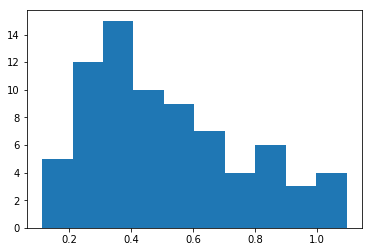

In [30]:
elasticite = pd.read_csv('coef_elasticite.csv')
elasticite = elasticite.drop(columns=['region', 'Cores2125_MAcatC1', 'Shortfall0611_obs', 
                                      'Shortfall0611_IGP', 'Shortfall1217_obs', 
                                      'Shortfall1217_IGP', 'S1', 'S2', 'S3', 'MLD_psu', 
                                      'survey', 'ThreeGen_IGPgsd', 'All2125_MEANp', 
                                      'All2125_IGP', 'All2125_IGP', 'All2125_MAcatC1', 
                                      'Cores2125_MEANp', 'Asher_Q4_IGpri', 
                                      'ThreeGen_IGPp1', 'ThreeGen_IGPg1', 
                                      'All2125_MEANc', 'Cores2125_MEANc', 
                                      'Cores2125_IGP','fragile', 'Q4_IGpri', 
                                      'BHQ1', 'BHQ2', 'BHQ3', 'BHQ4', 'Q4BH', 'Delta50', 
                                      'IGP', 'NL1', 'NL2', 'COR', 'MAcatM', 'MAcatC1', 
                                      'Q4child', 'ThreeGen_obs', 'C3', 'C4', 'C5', 
                                      'MEANp', 'MEANc', 'SDp', 'SDc', 'P1', 'P2', 'P3', 
                                      'P4', 'P5', 'C1', 'C2', 'GINIp', 'GINIc', 'cohort'])
#Faire ça autrement, ça prend trop de temps de tout enlever à la main comme ça

elasticite = elasticite.groupby(['countryname', 'iso3', 'IGEincome']).count()
elasticite = elasticite.reset_index()
elasticite = elasticite[['iso3', 'IGEincome']]
elasticite = elasticite.rename(columns={'IGEincome':'coef_elastic'})
plt.hist(elasticite['coef_elastic'])
plt.show()

Les coefficients datent de 1970, impossible de trouver des données plus récentes.

In [31]:
data_ela = pd.merge(data_gini, elasticite, how='left', left_on="code", right_on="iso3")
data_ela = data_ela[['Country', 'code', 'annee', 'quantile', 'nb_quantiles', 'income', 
                       'gdpppp', 'Gini', 'coef_elastic']]

any(pd.isnull(data_ela))

True

On a donc des pays qui ne sont pas dans elasticite, il va falloir calculer un coef d'elasticité pour ces pays là

In [32]:
(data_ela['coef_elastic'].isnull().sum()+1)/100 #+1 car on part de 0, /100 parce qu'on a 100 centiles par pays

33.0

33 Pays n'ont donc pas de valeur en coef elastic

In [33]:
#Visualisons les valeurs NaN : 
nan_rows = data_ela[data_ela.isnull().T.any().T]
nan_rows.groupby('Country').count().head()

,code,annee,quantile,nb_quantiles,income,gdpppp,Gini,coef_elastic
Country,,,,,,,,
Argentina,100,100,100,100,100,100,100,0
Armenia,100,100,100,100,100,100,100,0
Azerbaijan,100,100,100,100,100,100,100,0
Bulgaria,100,100,100,100,100,100,100,0
Cambodia,100,100,100,100,100,100,100,0


<p> Afin de récupérer une approximation du coef elastic des pays, nous allons ajouter la sous région et le continent au df ; Ensuite nous affecterons la moyenne de la sous région (ou du continent, selon ce qui est le mieux) comme coef : </p>

In [34]:
country_region = pd.read_csv('countryContinent.csv', encoding='latin')
country_region = country_region[['country', 'code_3', 'sub_region', 'continent']]

country_region.head()

,country,code_3,sub_region,continent
0,Afghanistan,AFG,Southern Asia,Asia
1,Åland Islands,ALA,Northern Europe,Europe
2,Albania,ALB,Southern Europe,Europe
3,Algeria,DZA,Northern Africa,Africa
4,American Samoa,ASM,Polynesia,Oceania


Les données sont issues de Kaggle : <br/> https://www.kaggle.com/statchaitya/country-to-continent

In [35]:
data_coef_ = pd.merge(data_ela, country_region, how='left', left_on='code', right_on='code_3')
data_coef_ = data_coef_[['Country', 'code', 'annee', 'quantile', 'nb_quantiles', 'income', 
                         'gdpppp', 'Gini', 'coef_elastic', 'sub_region', 'continent']]
print(any(pd.isnull(data_coef_['sub_region'])))

True


<p> Après vérification, le Kosovo n'est pas enregistré, nous allons donc le paramétrer à la main : </p>

In [36]:
data_coef_.loc[data_gini['code'] == 'XKX', 'continent'] = 'Europe'
data_coef_.loc[data_gini['code'] == 'XKX', 'sub_region'] = 'Southern Europe'
print(any(pd.isnull(data_coef_['sub_region'])))

False


On peut désormais remplacer les valeurs NaN par la moyenne de chaque région : 

In [37]:
coef_mean = data_coef_.groupby(['continent','sub_region']).mean()

coef_mean

annee  quantile  nb_quantiles        income  \
continent sub_region                                                         
Africa    Eastern Africa      2008.0  50.50000         100.0    692.480501   
          Middle Africa       2008.0  50.50000         100.0    543.657972   
          Southern Africa     2008.0  50.50000         100.0   5617.904880   
          Western Africa      2008.0  50.50000         100.0   1099.222144   
Americas  Caribbean           2008.0  50.50000         100.0   3558.402105   
          Central America     2008.0  50.50000         100.0   3904.427515   
          Northern America    2008.0  50.50000         100.0  24621.611090   
          South America       2008.0  50.50000         100.0   4062.722325   
Asia      Central Asia        2008.0  50.50000         100.0   2006.184508   
          Eastern Asia        2008.0  50.50000         100.0  16386.918100   
          South-Eastern Asia  2008.0  50.50000         100.0   1486.340247   
          Southern Asia       2008.0  50.50000         100.0   3360.247390   
          Western Asia        2008.0  50.50000         100.0   5071.391170   
Europe    Eastern Europe      2008.0  50.50000         100.0   5105.474446   
          Northern Europe     2008.0  50.50951         100.0  15952.682569   
          Southern Europe     2008.0  50.50000         100.0   8262.615999   
          Western Europe      2008.0  50.50000         100.0  18496.590650   
Oceania   Melanesia           2008.0  50.50000         100.0   2098.730882   

                                    gdpppp       Gini  coef_elastic  
continent sub_region                                                 
Africa    Eastern Africa      7.730000e+02  42.945000           NaN  
          Middle Africa       4.940965e+02  28.341998      0.707703  
          Southern Africa     9.602000e+03  64.355000      0.677000  
          Western Africa      1.876367e+03  40.392500           NaN  
Americas  Caribbean           7.505000e+03  50.716667           NaN  
          Central America     8.426500e+03  49.319167           NaN  
          Northern America    3.957800e+04  40.800000      0.403499  
          South America       8.295125e+03  49.395500      0.858733  
Asia      Central Asia        6.256000e+03  30.192500      0.295433  
          Eastern Asia        2.527033e+04  32.718333      0.305000  
          South-Eastern Asia  1.802000e+03  35.100000           NaN  
          Southern Asia       6.390500e+03   0.367155      0.450500  
          Western Asia        1.029144e+04  28.131472      0.429699  
Europe    Eastern Europe      1.378590e+04  31.903283      0.414511  
          Northern Europe     3.131174e+04  33.468358      0.334797  
          Southern Europe     1.699064e+04  31.086270      0.439281  
          Western Europe      4.084350e+04  33.590000      0.284700  
Oceania   Melanesia           4.300332e+06  42.780000           NaN

On peut voir ici que certaines sous région n'ont pas de valeur pour le coef, on va donc devoir prendre les continents. <br/>
Concernant l'Océanie, il faudra trouver la valeur ailleurs

In [38]:
coef_mean = data_coef_.groupby(['continent']).mean()
coef_mean = coef_mean.reset_index()
coef_mean = coef_mean[['continent', 'coef_elastic']]

coef_mean

,continent,coef_elastic
0,Africa,0.692351
1,Americas,0.728666
2,Asia,0.351970
3,Europe,0.370715
4,Oceania,NaN


<p> Concernant l'Océanie, nous allons devoir prendre une valeur arbitraire, prenons donc le base case donné dans le fichier elasticity.txt du sujet : <br/>
    Australia/New Zealand/USA : 0.4

In [39]:
coef_mean.loc[coef_mean.continent == 'Oceania', 'coef_elastic'] = 0.4

In [40]:
#On applique ensuite les coefs au df :
data_coef = data_coef_.copy()
means = data_coef.groupby('continent')['coef_elastic'].transform(np.mean)
filled_means = means.fillna(1)
data_coef['coef_elastic'] = data_coef['coef_elastic'].fillna(filled_means)

data_coef.head()

,Country,code,annee,quantile,nb_quantiles,income,gdpppp,Gini,coef_elastic,sub_region,continent
0,Albania,ALB,2008,1,100,728.89795,7297.0,29.98,0.815874,Southern Europe,Europe
1,Albania,ALB,2008,2,100,916.66235,7297.0,29.98,0.815874,Southern Europe,Europe
2,Albania,ALB,2008,3,100,1010.91600,7297.0,29.98,0.815874,Southern Europe,Europe
3,Albania,ALB,2008,4,100,1086.90780,7297.0,29.98,0.815874,Southern Europe,Europe
4,Albania,ALB,2008,5,100,1132.69970,7297.0,29.98,0.815874,Southern Europe,Europe


<p> Nous n'avons plus de valeur NaN pour le coef elastique </p>

## Définition des fonctions :

In [41]:
import scipy.stats as st
from collections import Counter 

In [42]:
#Question 1 à 3 :
def generate_incomes(n, pj):
    ln_y_parent = st.norm(0,1).rvs(size=n)
    
    residues = st.norm(0,1).rvs(size=n)
    
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

#Question 4 :
#Cette fonction permet de mettre chaque valeur dans son quantile respectif (en fonction du nombre de quantile)
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a, b in zip(l_sorted, quantiles)}
    return pd.Series([q_dict[e] for e in l])

#Cette fonction permet d'associer chaque revenu des parents et enfants en une classe de revenus
#Selon le nombre de quantile
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ['y_child', 'y_parents', 'c_i_child', 'c_i_parent']
    return sample


#Question 5 :
#Permet un calcul de la distribution de chaque quantile enfant par rapport au quantile parent 
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts['counts'].sum()
    
    if total == 0:
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset['counts'].values[0]
            distrib += [nb/total]
        else :
            distrib += [0]
    
    return distrib

#Calcul de la distribution conditionnelle : 
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(['c_i_child', 'c_i_parent']).apply(len)
    counts = counts.reset_index()
    counts.columns = ['c_i_child', 'c_i_parent', 'counts']
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    
    return np.array(mat)

#Question 6 :
#Plot de la distribution conditionnelle :
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    cumul = np.array([0]*nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom = cumul, 
                width = 0.95, label = str(i+1) + 'e')
        cumul = cumul + np.array(child_quantile)
        plt.axis([.5, nb_quantiles*1.3, 0, 1])
        plt.title('P='+str(p))
        plt.legend()
        plt.xlabel('quantile parents')
        plt.ylabel('Probabilité du quantile enfant')
        plt.show()

#Calcul de la probabilité conditionnelle :
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]



## Question 1 à 6 :

In [43]:
#Question 1 à 2 :
pj = 0.9
nb_quantiles = 100
n = 1000*nb_quantiles

#Question 3 : 
y_child, y_parents = generate_incomes(n, pj)

#Question 4 :
sample = compute_quantiles(y_child, y_parents, nb_quantiles)

#Question 5 :
cd = conditional_distributions(sample, nb_quantiles)

#plot_conditional_distributions(pj, cd, nb_quantiles) #prend beaucoup de temps

c_i_child = 5
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, 
                                                                   c_i_child,pj, p))

[0.68746667 0.63034084 6.14434149 ... 1.64701442 0.86777549 1.52721795]
[0.20154935 0.2281323  1.62173384 ... 0.63305753 2.5038885  5.80479444]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.024


Passons maintenant au plot stacked_bar ; Pour plus de lisibilité nous choisirons des déciles et non des centiles :

## Question 6 (mise en place du stacked bar) :

In [44]:
pj_2 = 0.9 
nb_quantiles_2 = 10
n_2 = 1000*nb_quantiles_2
y_child_2, y_parents_2 = generate_incomes(n_2, pj_2)
sample_2 = compute_quantiles(y_child_2, y_parents_2, nb_quantiles_2)
cd_2 = conditional_distributions(sample_2, nb_quantiles_2)

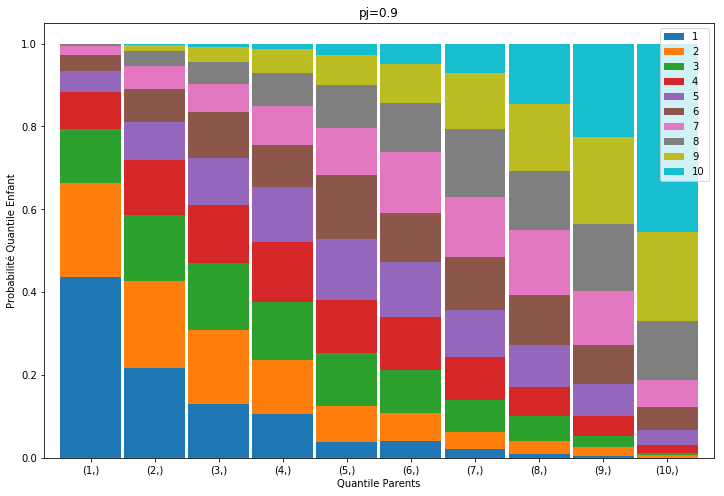

In [71]:
cd_df = pd.DataFrame(cd_2, columns = [np.arange(nb_quantiles_2)+1])
cd_df = cd_df.T #Voir avec Laura
cd_df.columns = np.arange(nb_quantiles_2)+1

cd_df.plot(kind="bar", figsize=(12,8), stacked=True, width=0.95)
plt.title("pj="+str(pj_2))
plt.xlabel("Quantile Parents")
plt.ylabel("Probabilité Quantile Enfant")
plt.xticks(rotation = 'horizontal')
plt.yticks(rotation = 'horizontal')
plt.savefig("Graphiques/barstacked_pj_haut.png")
plt.show()

In [46]:
pj_3 = 0.1 
nb_quantiles_3 = 10
n_3 = 1000*nb_quantiles_3
y_child_3, y_parents_3 = generate_incomes(n_3, pj_3)
sample_3 = compute_quantiles(y_child_3, y_parents_3, nb_quantiles_3)
cd_3 = conditional_distributions(sample_3, nb_quantiles_3)

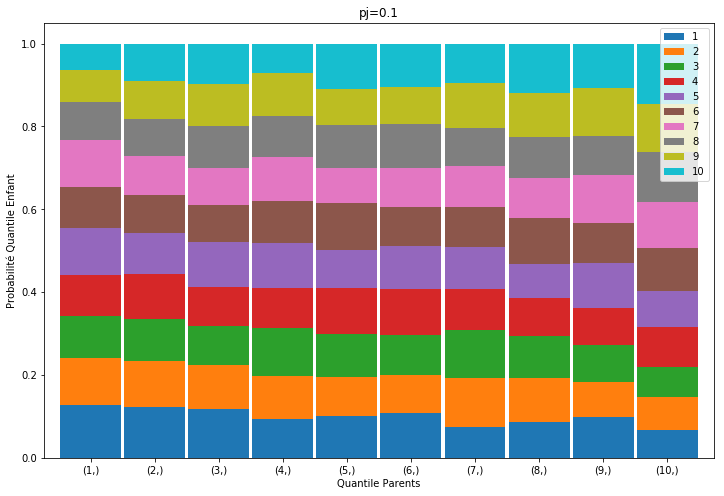

In [72]:
cd_df3 = pd.DataFrame(cd_3, columns = [np.arange(nb_quantiles_3)+1])
cd_df3 = cd_df3.T #Voir avec Laura
cd_df3.columns = np.arange(nb_quantiles_3)+1

cd_df3.plot(kind="bar", figsize=(12,8), stacked=True, width=0.95)
plt.title("pj="+str(pj_3))
plt.xlabel("Quantile Parents")
plt.ylabel("Probabilité Quantile Enfant")
plt.xticks(rotation = 'horizontal')
plt.yticks(rotation = 'horizontal')
plt.savefig("Graphiques/barstacked_pj_faible.png")
plt.show()

## Question 7 :

In [48]:
#On commence par effacer les variables inutiles, on garde les distributions conditionnelles
pj = None
nb_quantiles = None
n = None
y_child = None
y_parents = None
sample = None

## Question 8 :

<p>Pour cette question on va utiliser le fichier de la WID (donc notre df data_gini).</p>
<p>Nous allons créer 499 clones de chaque individus </p>

In [49]:
data_cloned = data_coef[['code', 'quantile', 'income', 'Gini', 'coef_elastic']]
data_cloned = pd.concat([data_cloned]*500, ignore_index=True)
data_cloned = data_cloned.sort_values(by=['code', 'quantile'])

#On reset les index pour avoir des index qui se suivent
data_cloned = data_cloned.reset_index()
data_cloned = data_cloned[['code', 'quantile', 'income', 'Gini', 'coef_elastic']]
data_cloned.head()

,code,quantile,income,Gini,coef_elastic
0,ALB,1,728.89795,29.98,0.815874
1,ALB,1,728.89795,29.98,0.815874
2,ALB,1,728.89795,29.98,0.815874
3,ALB,1,728.89795,29.98,0.815874
4,ALB,1,728.89795,29.98,0.815874


## Question 9 :

<p> On assigne maintenant à chaque individus la classe c_i_parents conformément aux distributions trouvées précédemment </p>

In [50]:
#On commence par multiplier la distribution par 500, on a maintenant le nombre d'individus à attribuer
#A chaque quantile
distrib = cd.copy()
distrib = distrib*500

distrib

array([[130.5,  54.5,  32.5, ...,   0. ,   0. ,   0. ],
       [ 50.5,  40. ,  46. , ...,   0. ,   0. ,   0. ],
       [ 37. ,  42. ,  33.5, ...,   0. ,   0. ,   0. ],
       ...,
       [  0. ,   0. ,   0. , ...,  38. ,  35.5,  45. ],
       [  0. ,   0. ,   0. , ...,  39.5,  51.5,  58. ],
       [  0. ,   0. ,   0. , ...,  37.5,  64. , 126. ]])

### Boucle 1 : un seul quantile, un seul pays

In [51]:
test = data_cloned[data_cloned['code'] == 'ALB']
test = test[test['quantile'] == 1]
test['c_i_parents'] = 1
test = test.reset_index()
test = test[['code', 'quantile', 'income', 'Gini', 'c_i_parents']]

#On essaye d'attribuer la valeur 1 de 0 à distrib 1
#base = 0
#quant = 1
#test.iloc[base:int(distrib[0,0]),4] = quant
#print(test)

#Ca fonctionne, on peut donc boucler la dessus :
base = 0
quant = 1
pair_impair = 0
for i in range(0,100):
    x = distrib[0,i]
    if x*10 %2 != 0:
        if pair_impair %2 == 0:
            up = base + int(distrib[0,i])
            pair_impair += 1
        else :
            up = base + int(distrib[0,i])+1
            pair_impair += 1
    else:
        up = base + int(distrib[0,i])
    test.iloc[base:up,4] = quant
    base = up
    quant = quant+1
    
    
test.head()

,code,quantile,income,Gini,c_i_parents
0,ALB,1,728.89795,29.98,1
1,ALB,1,728.89795,29.98,1
2,ALB,1,728.89795,29.98,1
3,ALB,1,728.89795,29.98,1
4,ALB,1,728.89795,29.98,1


La boucle fonctionne !!

### Boucle 2 : Tous les quantiles, un seul pays

In [52]:
import time

Double boucle un peu chimique, à voir comment optimiser ça

In [53]:
#Calcul du temps d'execution de la fonction :
t0 = time.process_time()

test = data_cloned[data_cloned['code'] == 'ALB'].copy()
test['c_i_parents'] = 1
test = test.reset_index()
test = test[['code', 'quantile', 'income', 'Gini', 'c_i_parents']]

result = []
for j in range(0,100):
    beta = test[test['quantile'] == j+1].copy()
    base = 0
    pair_impair = 0
    for i in range(0,100):
        x = distrib[j,i]
        if x*10 %2 != 0:
            if pair_impair %2 == 0:
                up = base + int(distrib[j,i])
                pair_impair += 1
            else :
                up = base + int(distrib[j,i])+1
                pair_impair += 1
        else:
            up = base + int(distrib[j,i])
        
        beta.iloc[base:up,4] = i+1
        base = up
    result.append(beta)
result = pd.concat(result)
    #df.append() ou .loc ou .iloc

#Temps d'execution :
t1 = time.process_time()
print("\n")
print ('Function elapsed in: ', t1-t0, 's')



Function elapsed in:  7.953125 s


Fonctionne !!!

In [54]:
result.head()

,code,quantile,income,Gini,c_i_parents
0,ALB,1,728.89795,29.98,1
1,ALB,1,728.89795,29.98,1
2,ALB,1,728.89795,29.98,1
3,ALB,1,728.89795,29.98,1
4,ALB,1,728.89795,29.98,1


### Boucle 3 : Tous les quantiles, tous les pays

<p> Avant toute chose, il nous faut les distrib_cond pour chaque coef_elastic des pays </p>

<p> Nous allons donc boucler les fonctions précédentes pour avoir chacune des distributions : </p>

In [55]:
t0 = time.process_time()

dist = []
for rho_j in data_coef['coef_elastic']:
    pj = rho_j
    nb_quantiles = 100
    n_ = 1000*nb_quantiles
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    dist.append(cd*500)

    
t1 = time.process_time()
print("\n")
print ('Function elapsed in: ', (t1-t0)/60, 'min')



Function elapsed in:  23.824479166666666 min


In [56]:
data_cloned['code'].unique()

array(['ALB', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BGR', 'BLR', 'BOL',
       'BRA', 'CAF', 'CAN', 'CIV', 'COD', 'COL', 'CRI', 'CYP', 'CZE',
       'DEU', 'DNK', 'DOM', 'ECU', 'ESP', 'EST', 'FIN', 'FJI', 'FRA',
       'GBR', 'GEO', 'GRC', 'HND', 'HRV', 'HUN', 'IRL', 'IRN', 'IRQ',
       'ISL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ', 'KGZ', 'KHM', 'KOR',
       'LTU', 'LUX', 'LVA', 'MDA', 'MEX', 'MKD', 'MNE', 'MOZ', 'MRT',
       'NLD', 'NOR', 'PAK', 'PER', 'POL', 'PRT', 'PRY', 'ROU', 'RUS',
       'SLV', 'SRB', 'SVK', 'SVN', 'SWE', 'TUR', 'TWN', 'UKR', 'URY',
       'USA', 'XKX', 'YEM', 'ZAF'], dtype=object)

In [57]:
#Test avec une nouvelle boucle :
t0 = time.process_time()
nb_quant = 100
data_cloned['c_i_parents'] = 1
result = []
for pays, k in zip(data_cloned['code'].unique(), range(0,len(data_cloned))):
    df = data_cloned[data_cloned['code'] == pays].copy()
    for j in range(0,nb_quant):
        beta = df[df['quantile'] == j+1].copy()
        base = 0
        pair_impair = 0
        for i in range(0,nb_quant):
            x = dist[k][j,i]
            if x*10 %2 != 0:
                if pair_impair %2 == 0:
                    up = base + int(dist[k][j,i])
                    pair_impair += 1
                else :
                    up = base + int(dist[k][j,i])+1
                    pair_impair += 1
            else:
                up = base + int(dist[k][j,i])

            beta.iloc[base:up,5] = i+1
            base = up
        result.append(beta)
result = pd.concat(result)

t1 = time.process_time()
print("\n")
print ('Function elapsed in: ', (t1-t0)/60, 'min')



Function elapsed in:  10.132291666666667 min


In [58]:
result.head()

,code,quantile,income,Gini,coef_elastic,c_i_parents
0,ALB,1,728.89795,29.98,0.815874,1
1,ALB,1,728.89795,29.98,0.815874,1
2,ALB,1,728.89795,29.98,0.815874,1
3,ALB,1,728.89795,29.98,0.815874,1
4,ALB,1,728.89795,29.98,0.815874,1


<p> Les boucles fonctionnent correctement, mais mettent beaucoup de temps à tourner ; Voir si possibilité de faire autrement</p>

<p> Nous avons donc notre df final, passons maintenant à la mission 4 </p>

In [59]:
#Enlevons quand même la variable C_i_child pour éviter toute confusion : 

df_final = result.copy()
df_final = df_final.drop(columns='quantile')

#Et ajoutons la colonne mean_income : 
mean_count = df_final.groupby('code').mean()
mean_count = mean_count.reset_index()
mean_count = mean_count[['code', 'income']]
mean_count = mean_count.rename(columns={'income':'mean_income'})

df_final = pd.merge(df_final, mean_count, left_on='code', right_on='code', how='left')

df_final.head()

,code,income,Gini,coef_elastic,c_i_parents,mean_income
0,ALB,728.89795,29.98,0.815874,1,2994.829902
1,ALB,728.89795,29.98,0.815874,1,2994.829902
2,ALB,728.89795,29.98,0.815874,1,2994.829902
3,ALB,728.89795,29.98,0.815874,1,2994.829902
4,ALB,728.89795,29.98,0.815874,1,2994.829902


# Mission 4

In [60]:
import statsmodels.formula.api as smf

## ANOVA

In [61]:
anova_pays = smf.ols('income~code', data=df_final).fit()
print(anova_pays.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 4.064e+04
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:34:18   Log-Likelihood:            -3.9530e+07
No. Observations:             3799500   AIC:                         7.906e+07
Df Residuals:                 3799424   BIC:                         7.906e+07
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2994.8299     35.703     83.883      

<p> Test de Ficher : <br/>
    La p_valeur = 0 . Bizarre, à creuser quand même <br/>
    On pouvait se douter que le pays a effectivement un impact sur les revenus, de là à avoir une p_valeur égale à zéro...</p>

2 pays ne sont pas significatifs, il faudra les enlever

In [62]:
import statsmodels.api as sm
anov_table = sm.stats.anova_lm(anova_pays, typ=2)
anov_table

,sum_sq,df,F,PR(>F)
code,1.942574e+14,75.0,40639.163243,0.0
Residual,2.421527e+14,3799424.0,NaN,NaN


## Régressions Linéaires

### Income sans logarithme

In [63]:
reg_multi = smf.ols("income~Gini+mean_income", data=df_final).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.524e+06
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:34:24   Log-Likelihood:            -3.9530e+07
No. Observations:             3799500   AIC:                         7.906e+07
Df Residuals:                 3799497   BIC:                         7.906e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.495e-08     12.748  -1.17e-09      

<p>On voit sur cette régression que l'indice de Gini n'est pas significatif, on peut donc l'enlever</p>

<p> Il semble même qu'il y ait une colinéarité entre Gini et income </p>

In [64]:
reg_multi = smf.ols("income~mean_income", data=df_final).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 3.048e+06
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:34:26   Log-Likelihood:            -3.9530e+07
No. Observations:             3799500   AIC:                         7.906e+07
Df Residuals:                 3799498   BIC:                         7.906e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.223e-10      6.282  -8.31e-11      

<p> Le paramètre est ici significatif, et on obtient un R-squared de 0.445 </p>
    
<p> La décomposition de variance totale expliquée pour le pays de naissance est donc égale à 0.445 </p>

<p> Et pour les autres facteurs, on a 1-0.445 = 0.555 ? </p>

<p> Intercept à 1 par contre, voir explications </p>

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [66]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[0.999999999999887]

Pas de problème de colinéarité

### Income logarithme

In [67]:
reg_multi_ln = smf.ols("income~Gini+mean_income.apply(np.log)", data=df_final).fit()
print(reg_multi_ln.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                 1.065e+06
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:34:30   Log-Likelihood:            -3.9804e+07
No. Observations:             3799500   AIC:                         7.961e+07
Df Residuals:                 3799497   BIC:                         7.961e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

<p> En passant la variable mean_income en logarithm on obtient deux paramètres significatifs, cependant, on peut voir que le R-squared est faible : 0.359  </p>

<p> On gardera tout de même ce modèle puisqu'il contient plus de paramètres </p>

<p> La décomposition de variance totale expliquée pour le pays de naissance est donc égale à 0.359 </p>

<p> Et pour les autres facteurs, on a 1-0.359 = 0.641 ? </p>

## Amélioration du modèle :  

### Income sans logarithme

In [68]:
reg_multi = smf.ols("income~mean_income+c_i_parents", data=df_final).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                 1.548e+06
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:34:33   Log-Likelihood:            -3.9517e+07
No. Observations:             3799500   AIC:                         7.903e+07
Df Residuals:                 3799497   BIC:                         7.903e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    6731.2139     41.898    160.657      

<p> Les paramètres sont bien significatifs, et on obtient un R-squared de 0.449 ! </p>

In [69]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0000000000093245, 1.0000000000095044]

Pas de colinéarité 

### Income logarithme

In [70]:
reg_multi_ln = smf.ols("income~Gini+mean_income.apply(np.log)+c_i_parents", 
                       data=df_final).fit()

print(reg_multi_ln.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                 7.216e+05
Date:                Tue, 02 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:34:39   Log-Likelihood:            -3.9793e+07
No. Observations:             3799500   AIC:                         7.959e+07
Df Residuals:                 3799496   BIC:                         7.959e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

<p> Les paramètres sont là aussi significatifs, cependant le R-squared est inférieur à la reg précédente : 0.363 </p>

<p> On gardera quand même ce modèle, qui encore une fois présente plus de paramètres </p>

<p> L'indice de Gini est placé en coefficient négatif, ce qui veut dire que plus l'Income est grand, plus l'indice est petit ? REVOIR CE POINT </p>